In [7]:
import os
import re
import matplotlib.pyplot as plt

In [8]:
def extract_protein(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE):
    protein_sequences = []        
    missing_file_folders = []    
    protein_not_found_folders = {}  # Dicionário para armazenar pastas e motivos
    discarded_by_size = {}  
    tamanhos_sequencias = []     
  
    # Expressão regular revisada para evitar proteínas compostas (ex: "gag-pol")
    exact_match = re.compile(rf'(?<![a-zA-Z0-9-]){protein_name}(?![a-zA-Z0-9-])', re.IGNORECASE)
    term_exclusion = re.compile(r'\b(truncated|fragment)\b', re.IGNORECASE)

    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)
        if not os.path.isdir(folder_path):
            continue
            
        file_path = os.path.join(folder_path, "protein.faa")
        if not os.path.exists(file_path):
            missing_file_folders.append(folder)
            continue
            
        found = False  
        current_header = None
        current_sequence = []
        
        # Variáveis para rastrear motivos
        has_correct_gene = False
        has_excluded_terms = False
        
        with open(file_path, "r") as file:
            for line in file:
                line = line.strip()
                
                if line.startswith(">"):
                    if current_header:
                        valid_gene_current = bool(exact_match.search(current_header))
                        header_clean_current = not term_exclusion.search(current_header.lower())
                        
                        # Atualiza os motivos
                        if valid_gene_current:
                            has_correct_gene = True
                            if not header_clean_current:
                                has_excluded_terms = True

                        seq_length = len(''.join(current_sequence))
                        
                        if valid_gene_current and header_clean_current:
                            if MIN_SIZE <= seq_length <= MAX_SIZE:
                                new_header = f"{current_header} tamanho: {seq_length}"
                                protein_sequences.append(f"{new_header}\n{''.join(current_sequence)}")
                                tamanhos_sequencias.append(seq_length)
                                found = True
                            else:
                                discarded_by_size[folder] = current_header

                    current_header = line
                    current_sequence = []
                else:
                    current_sequence.append(line)
            
            if current_header:
                valid_gene_current = bool(exact_match.search(current_header))
                header_clean_current = not term_exclusion.search(current_header.lower())
                
                # Atualiza os motivos
                if valid_gene_current:
                    has_correct_gene = True
                    if not header_clean_current:
                        has_excluded_terms = True
                
                seq_length = len(''.join(current_sequence))
                
                if valid_gene_current and header_clean_current:
                    if MIN_SIZE <= seq_length <= MAX_SIZE:
                        new_header = f"{current_header} tamanho: {seq_length}"
                        protein_sequences.append(f"{new_header}\n{''.join(current_sequence)}")
                        tamanhos_sequencias.append(seq_length)
                        found = True
                    else:
                        discarded_by_size[folder] = current_header
        
        # Determina os motivos após processar todos os cabeçalhos
        if not found and folder not in discarded_by_size:
            reasons = []
            if not has_correct_gene:
                reasons.append(f"Não há {protein_name}")
            if has_excluded_terms:
                reasons.append("Termos proibidos no cabeçalho")
            if reasons:
                protein_not_found_folders[folder] = reasons

    if protein_sequences:
        with open(output_file, "w") as fasta_file:
            fasta_file.write("\n".join(protein_sequences) + "\n")
        print(f"✅ Arquivo {output_file} gerado com {len(protein_sequences)} sequências.")

    print("\n=== DIAGNÓSTICO ===")
    print(f"Total de tamanhos armazenados: {len(tamanhos_sequencias)}")
    print(f"Pastas sem arquivo: {len(missing_file_folders)}")
    print(f"Pastas com arquivo inválido: {len(protein_not_found_folders)}")
    print(f"Pastas com sequências descartadas por tamanho inadequado: {len(discarded_by_size)}")
    print(f"Total problemático: {len(missing_file_folders) + len(protein_not_found_folders) + len(discarded_by_size)}\n")
    
    if missing_file_folders:
        print("🔍 Pastas sem arquivo:") 
        for folder in missing_file_folders:
            print(f"   - {folder}")
    
    if protein_not_found_folders:
        print("\n🔍 Pastas com arquivo inválido:")  
        for folder, reasons in protein_not_found_folders.items():
            print(f"   - {folder}: {', '.join(reasons)}")

    if discarded_by_size:
        print("\n🔍 Pastas com sequências descartadas por tamanho inadequado:")
        print(f"   (Critério: tamanho aceitável entre {MIN_SIZE} e {MAX_SIZE} nucleotídeos)")
        for folder, header in discarded_by_size.items():
            print(f"   - {folder}: {header}")

    return tamanhos_sequencias

In [9]:
def plot(tamanhos_sequencias, protein_name): 
    # Dados de exemplo (substitua pela sua lista de tamanhos_sequencias)
    # tamanhos_sequencias = [1500, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

    # Criar lista de índices para o eixo X
    indices = range(len(tamanhos_sequencias))

    # Criar gráfico de dispersão
    plt.figure(figsize=(10, 5))  # Define o tamanho da figura
    plt.scatter(indices, tamanhos_sequencias, color='blue', alpha=0.7)  # Plota os pontos

    # Configurações do gráfico
    plt.xlabel("Índice da Sequência", fontsize=12)  # Rótulo do eixo X
    plt.ylabel("Tamanho da Sequência (nucleotídeos)", fontsize=12)  # Rótulo do eixo Y
    plt.title(f"Tamanho das Sequências do {protein_name}", fontsize=14, fontweight='bold')  # Título
    plt.grid(linestyle='--', alpha=0.7)  # Adiciona grid

    # Exibir gráfico
    plt.show()
    # Dados de exemplo (substitua pela sua lista de tamanhos_sequencias)
    # tamanhos_sequencias = [1500, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

    # Criar histograma
    plt.figure(figsize=(10, 5))  # Define o tamanho da figura
    plt.hist(tamanhos_sequencias, bins=20, edgecolor='black', color='skyblue')  # Plota o histograma

    # Configurações do gráfico
    plt.xlabel("Tamanho da sequência (nucleotídeos)", fontsize=12)  # Rótulo do eixo X
    plt.ylabel("Frequência", fontsize=12)  # Rótulo do eixo Y
    plt.title(f"Distribuição do Tamanho do {protein_name}", fontsize=14, fontweight='bold')  # Título
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adiciona grid no eixo Y

    # Exibir gráfico
    plt.show()

MUDE AQUI PARA O NOME DA PROTEINA, O ARQUIVO DE SAIDA .FASTA, E O RANGE DE TAMANHO QUE QUER USAR

✅ Arquivo gag.fasta gerado com 425 sequências.

=== DIAGNÓSTICO ===
Total de tamanhos armazenados: 425
Pastas sem arquivo: 26
Pastas com arquivo inválido: 41
Pastas com sequências descartadas por tamanho inadequado: 9
Total problemático: 76

🔍 Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

🔍 Pastas com arquivo inválido:
   - GCA_003097955.1: Termos proibidos no cabeçalho
   - GCA_003098355.1: Não há gag
   - GCA_003098655.1: Não há gag
   - GCA_003099135.1: Não há gag
   - GC

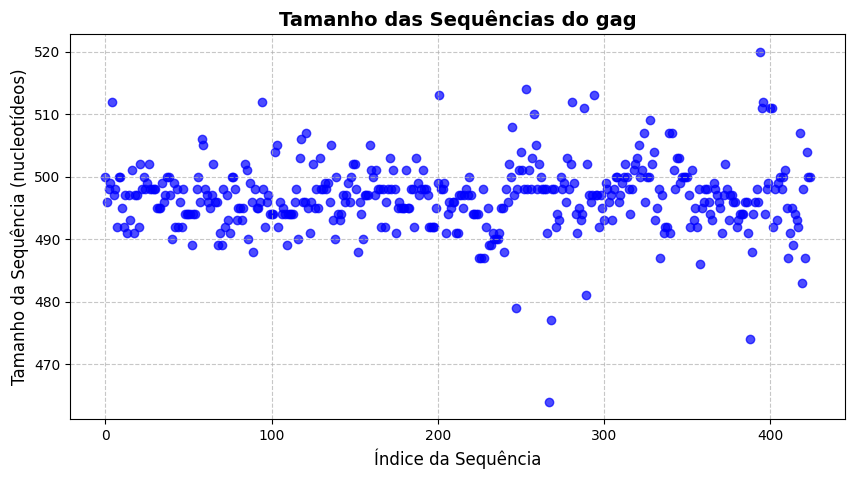

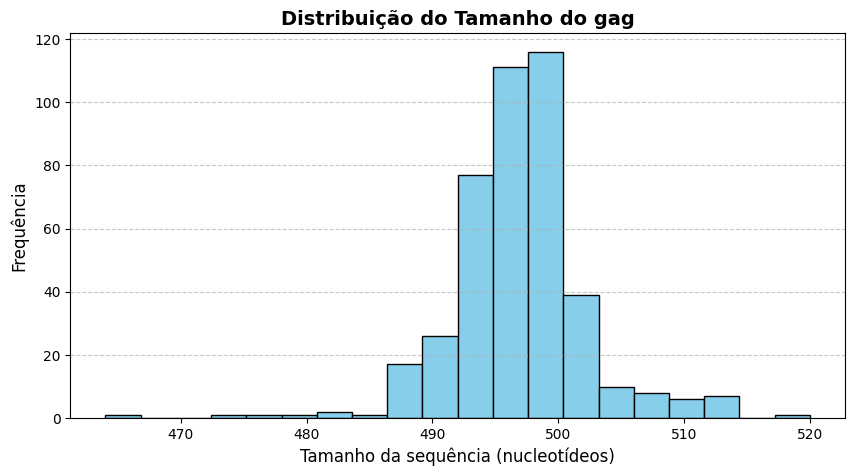

In [ ]:
# Configuração direta. 
root_folder = "data"
protein_name = "gag" 
output_file = "gag.fasta"
MIN_SIZE = 400
MAX_SIZE = 600

tamanhos_sequencias = extract_protein(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)